In [229]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import csv
import glob
import os
import numpy as np
import matplotlib.dates as mdates
from numpy.linalg import inv

In [230]:
# Reads monthly exchange rates from CHF to USD and writes the inverted rates (USD to CHF) to a new file.

input_file = 'data/monthly_exchange_rate/monthly_CHF_to_one_USD.csv'
output_file = 'data/monthly_exchange_rate/monthly_USD_to_one_CHF.csv'

with open(input_file, mode='r', newline='') as infile, open(output_file, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    
    fieldnames = ['date', 'EXUSSZ']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for row in reader:
        try:
            original_rate = float(row['EXSZUS'])
            inverted_rate = 1 / original_rate
            writer.writerow({
                'date': row['date'],
                'EXUSSZ': round(inverted_rate, 4)
            })
        except (ValueError, ZeroDivisionError):
            print(f"Skipped invalid row: {row}")

In [231]:
# Reads monthly exchange rates from JPY to USD and writes the inverted rates (USD to JPY) to a new file.

input_file = 'data/monthly_exchange_rate/monthly_JPY_to_one_USD.csv'
output_file = 'data/monthly_exchange_rate/monthly_USD_to_one_JPY.csv'

with open(input_file, mode='r', newline='') as infile, open(output_file, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    
    fieldnames = ['date', 'EXUSJP']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for row in reader:
        try:
            original_rate = float(row['EXJPUS'])
            inverted_rate = 1 / original_rate
            writer.writerow({
                'date': row['date'],
                'EXUSJP': round(inverted_rate, 4)
            })
        except (ValueError, ZeroDivisionError):
            print(f"Skipped invalid row: {row}")

In [232]:
# loads monthly USD exchange rate data for five currencies, 
# renames the columns for clarity, merges them into a single DataFrame, 
# and saves the result as a CSV file.


# Load exchange rate data for each currency (USD to one unit of foreign currency)
df_chf_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_CHF.csv')
df_jpy_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_JPY.csv')
df_aud_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_AUD.csv')
df_eur_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_EUR.csv')
df_gbp_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_GBP.csv')

# Rename the columns for clarity, representing the exchange rate from USD to each currency
df_chf_rate.rename(columns={'EXUSSZ': 'USD_per_CHF'}, inplace=True)
df_jpy_rate.rename(columns={'EXUSJP': 'USD_per_JPY'}, inplace=True)
df_aud_rate.rename(columns={'EXUSAL': 'USD_per_AUD'}, inplace=True)
df_eur_rate.rename(columns={'EXUSEU': 'USD_per_EUR'}, inplace=True)
df_gbp_rate.rename(columns={'EXUSUK': 'USD_per_GBP'}, inplace=True)

# Merge all the exchange rate dataframes on the 'date' column, using outer joins to retain all dates
df_merged_rates = df_chf_rate[['date', 'USD_per_CHF']].merge(df_jpy_rate[['date', 'USD_per_JPY']], on='date', how='outer') \
    .merge(df_aud_rate[['date', 'USD_per_AUD']], on='date', how='outer') \
    .merge(df_eur_rate[['date', 'USD_per_EUR']], on='date', how='outer') \
    .merge(df_gbp_rate[['date', 'USD_per_GBP']], on='date', how='outer')

# Convert the 'date' column to datetime format
df_merged_rates['date'] = pd.to_datetime(df_merged_rates['date']).dt.to_period('M').dt.to_timestamp()

# Setting the date column as the index
df_merged_rates.set_index('date', inplace=True)

# Remove the first row to match 3-month interbank data
df_merged_rates = df_merged_rates.iloc[1:]

# Create the directory if it doesn't exist
os.makedirs('data/preprocess', exist_ok=True)

# Save the merged exchange rate data to a new CSV file
df_merged_rates.to_csv('data/preprocess/merged_exchange_rates.csv')

# Display the first few rows of the final merged DataFrame
df_merged_rates.head()

,USD_per_CHF,USD_per_JPY,USD_per_AUD,USD_per_EUR,USD_per_GBP
date,,,,,
2002-05-01,0.6294,0.0079,0.5498,0.9170,1.4598
2002-06-01,0.6494,0.0081,0.5682,0.9561,1.4837
2002-07-01,0.6794,0.0085,0.5538,0.9935,1.5565
2002-08-01,0.6679,0.0084,0.5413,0.9781,1.5368
2002-09-01,0.6697,0.0083,0.5465,0.9806,1.5563


In [233]:
# Import the T-Bill data
df_tbills = pd.read_csv('data/monthly_returns/tbills.csv')

# Convert the 'date' column to datetime and shift to the beginning of the next month
df_tbills['date'] = (pd.to_datetime(df_tbills['date']) + pd.offsets.MonthBegin(1))

# Set the date column as the index
df_tbills.set_index('date', inplace=True)

# Remove the last row to match monthly returns data
df_tbills = df_tbills.iloc[:-1]

# Save the processed T-Bill data to a new CSV file
df_tbills.to_csv('data/preprocess/tbills.csv')

# Display the first few rows of the final DataFrame
df_tbills.head()

,rf
date,
2002-05-01,0.0015
2002-06-01,0.0014
2002-07-01,0.0013
2002-08-01,0.0015
2002-09-01,0.0014


In [234]:
# Loads monthly returns data for various countries, merges the data with CRSP (US returns) and T-bills data, 
# and standardizes the columns to include the returns for each country in the correct format, 
# before saving the final merged DataFrame.


# Folder path containing the return data files
path = "data/monthly_returns/"

# List of country-specific return files (excluding 'csrp_return.csv' and 'tbills.csv')
country_files = [
    "australia_return.csv", "france_return.csv", "germany_return.csv",
    "japan_return.csv", "swiss_return.csv", "uk_return.csv"
]

# Initialize an empty DataFrame for storing merged monthly returns data
df_all_country_returns = None

# Load and process country-specific return data files
for file in country_files:
    # Load each country's return file
    df_country_return = pd.read_csv(path + file)

    # Extract country and currency from the first row
    country = df_country_return['country'].iloc[0].lower()   # e.g., "AUSTRALIA" -> "australia"
    currency = df_country_return['currency'].iloc[0].lower() # e.g., "AUD" -> "aud"

    # Manually fix uk
    if country == "united kingdom":
        country = "uk"

    # Convert the 'date' column to datetime and shift to the beginning of the next month
    df_country_return['date'] = pd.to_datetime(df_country_return['date']) + pd.offsets.MonthBegin(1)

    # Keep only relevant columns
    df_country_return = df_country_return[['date', 'mportret', 'mportretx']]

    # Rename columns to include the country and currency
    df_country_return = df_country_return.rename(columns={
        'mportret': f'{country}_ret_with_div_{currency}',
        'mportretx': f'{country}_ret_without_div_{currency}'
    })

    # Merge the current country's data into the final DataFrame
    if df_all_country_returns is None:
        df_all_country_returns = df_country_return
    else:
        df_all_country_returns = pd.merge(df_all_country_returns, df_country_return, on='date', how='outer')

# Load and process the CRSP (US returns) data
df_crsp_returns = pd.read_csv(path + "csrp_return.csv")
df_crsp_returns['date'] = pd.to_datetime(df_crsp_returns['date']) + pd.offsets.MonthBegin(1)
df_crsp_returns = df_crsp_returns[['date', 'vwretd', 'vwretx']]
df_crsp_returns = df_crsp_returns.rename(columns={
    'vwretd': 'us_ret_with_div_usd',
    'vwretx': 'us_ret_without_div_usd'
})
# Merge CRSP returns with the existing DataFrame
df_all_country_returns = pd.merge(df_all_country_returns, df_crsp_returns, on='date', how='outer')

# Sort the final DataFrame by 'date' and reset the index
df_all_country_returns = df_all_country_returns.sort_values('date')

# Setting the date column as the index
df_all_country_returns.set_index('date', inplace=True)

# Separate columns that contain returns with and without dividends
df_returns_with_div = df_all_country_returns.filter(like='_ret_with_div_')
df_returns_without_div = df_all_country_returns.filter(like='_ret_without_div_')

# Remove the last row to match monthly returns data
df_returns_with_div = df_returns_with_div.iloc[:-1]
df_returns_without_div = df_returns_without_div.iloc[:-1]

# Save both DataFrames to separate CSV files
df_returns_with_div.to_csv("data/preprocess/merged_returns_with_dividends.csv")
df_returns_without_div.to_csv("data/preprocess/merged_returns_without_dividends.csv")

# Display the first few rows of the with dividends DataFrame
df_returns_with_div.head()

,australia_ret_with_div_aud,france_ret_with_div_eur,germany_ret_with_div_eur,japan_ret_with_div_jpy,switzerland_ret_with_div_chf,uk_ret_with_div_gbp,us_ret_with_div_usd
date,,,,,,,
2002-05-01,-0.014302,-0.043988,-0.045031,0.020586,-0.004109,-0.013362,-0.049600
2002-06-01,-0.000204,-0.028016,-0.025703,0.035987,0.002963,-0.011482,-0.010510
2002-07-01,-0.026756,-0.080806,-0.068682,-0.083764,-0.081687,-0.082525,-0.070259
2002-08-01,-0.037816,-0.104069,-0.108894,-0.057720,-0.132371,-0.089530,-0.081125
2002-09-01,0.016208,-0.004621,-0.002896,-0.024411,0.005083,0.002874,0.007949


In [235]:
# This code processes the interbank rate data for multiple countries, 
# merges them into a single DataFrame with the date as the index, 
# and renames the columns to explicitly indicate the three-month interbank rates for each country 
# (AUD, CHF, EUR, GBP, JPY, US).


# Define the path to the folder containing the interbank rate files
path = "data/three_month_interbank_rate/"

# List of country files (with the format country_three_month_interbank_rate)
country_files = [
    "three_month_interbank_rate_AUD.csv", 
    "three_month_interbank_rate_CHF.csv", 
    "three_month_interbank_rate_EUR.csv",
    "three_month_interbank_rate_GBP.csv", 
    "three_month_interbank_rate_JPY.csv", 
    "three_month_interbank_rate_USD.csv"
]

# Initialize the final merged DataFrame with None
df_three_month_rates_merged = None

# Loop through each file and process the data
for file in country_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path + file)

    # Extract country name from the filename (assume the pattern is 'three_month_interbank_rate_<country>.csv')
    country = file.split('_')[4].split('.')[0].lower()  # e.g. 'AUD' for Australia

    # Rename the columns for better understanding with explicit names
    df = df.rename(columns={
        df.columns[1]: f'three_month_interbank_rate_{country.upper()}'  # Explicit column names
    })

    # Convert 'observation_date' to datetime and standardize the format to YYYY-MM
    df['observation_date'] = pd.to_datetime(df['observation_date']).dt.to_period('M').dt.to_timestamp()

    # Keep only the 'observation_date' and the relevant rate column
    df = df[['observation_date', f'three_month_interbank_rate_{country.upper()}']]

    # Merge with the final DataFrame
    if df_three_month_rates_merged is None:
        df_three_month_rates_merged = df
    else:
        df_three_month_rates_merged = pd.merge(df_three_month_rates_merged, df, on='observation_date', how='outer')

# Sort the final merged DataFrame by 'observation_date'
df_three_month_rates_merged = df_three_month_rates_merged.sort_values('observation_date').reset_index(drop=True)

# Rename the 'observation_date' column to 'date' for consistency
df_three_month_rates_merged.rename(columns={'observation_date': 'date'}, inplace=True)

# Iterate through all currency columns to check for missing values
currency_columns = [col for col in df_three_month_rates_merged.columns if 'three_month_interbank_rate_' in col]

# Check for missing values for each currency and print the dates associated
for col in currency_columns:
    missing_data = df_three_month_rates_merged[df_three_month_rates_merged[col].isna()]
    
    if not missing_data.empty:
        print(f"Missing data for {col.split('_')[-1].upper()}:")
        print(missing_data[['date', col]])
        print("\n")

Missing data for USD:
          date  three_month_interbank_rate_USD
216 2020-04-01                             NaN




In [236]:
# Fills the missing value in US three-month interbank rate series by averaging March and May 2020 
# for the missing US value in April 2020, then saves the cleaned dataset to a CSV file.


# Getting the values for March and May 2020
us_col = 'three_month_interbank_rate_USD'
us_mar_val = df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2020-03-01'), us_col
].values[0]
us_may_val = df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2020-05-01'), us_col
].values[0]

# Compute the mean if both values are not NaN
us_avg = np.nanmean([us_mar_val, us_may_val])

# Set April 2020 value
df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2020-04-01'), us_col
] = us_avg

# Convert all numeric columns (interest rates) from percent to decimal
numeric_cols = df_three_month_rates_merged.select_dtypes(include=[np.number]).columns
df_three_month_rates_merged[numeric_cols] = df_three_month_rates_merged[numeric_cols] / 100

# Set date as index
df_three_month_rates_merged.set_index('date', inplace=True)

# Remove the first row to match the previous data
df_three_month_rates_merged = df_three_month_rates_merged.iloc[1:]

# Save the merged DataFrame to a CSV file
df_three_month_rates_merged.to_csv(f"data/preprocess/merged_three_month_interbank_rates.csv")

# Display the final DataFrame
df_three_month_rates_merged.head()

,three_month_interbank_rate_AUD,three_month_interbank_rate_CHF,three_month_interbank_rate_EUR,three_month_interbank_rate_GBP,three_month_interbank_rate_JPY,three_month_interbank_rate_USD
date,,,,,,
2002-05-01,0.0484,0.011635,0.034671,0.041537,0.0008,0.0182
2002-06-01,0.0507,0.011496,0.034640,0.041776,0.0009,0.0181
2002-07-01,0.0498,0.010031,0.034100,0.040605,0.0009,0.0179
2002-08-01,0.0496,0.006683,0.033519,0.039865,0.0007,0.0173
2002-09-01,0.0492,0.006130,0.033101,0.039887,0.0008,0.0176


3.a) Compute the returns to each of the stock market indexes in USD by converting the
local currency returns into USD using the appropriate exchange rate

In [237]:
# Q3A

# Load the country returns data (only with dividends)
df_country_returns = pd.read_csv("data/preprocess/merged_returns_with_dividends.csv", parse_dates=['date'], index_col='date')

# Load the exchange rate data
df_exchange_rates = pd.read_csv("data/preprocess/merged_exchange_rates.csv", parse_dates=['date'], index_col='date')

# Merge the exchange rate data with the country returns data on 'date'
df_country_returns = pd.merge(df_country_returns, df_exchange_rates, on='date', how='left')

# Mapping from currency codes to exchange rate columns (USD per unit of foreign currency)
currency_to_fx_col = {
    'aud': 'USD_per_AUD',
    'eur': 'USD_per_EUR',
    'chf': 'USD_per_CHF',
    'jpy': 'USD_per_JPY',
    'gbp': 'USD_per_GBP'
}

# Compute exchange rate returns (Rex) in USD
for curr, fx_col in currency_to_fx_col.items():
    df_country_returns[f'Rex_{curr}'] = df_country_returns[fx_col].pct_change()

# Convert all local returns with dividends to USD returns using logarithmic approximation
converted_cols = {}

for col in df_country_returns.columns:
    if '_ret_with_div_' in col:
        for curr, fx_col in currency_to_fx_col.items():
            if col.endswith(f'_{curr}'):
                rex_col = f'Rex_{curr}'
                new_col = col.replace(f'_{curr}', '_usd')
                df_country_returns[new_col] = (df_country_returns[col] + 1) * (df_country_returns[rex_col] + 1) - 1
                converted_cols[col] = new_col
                break

# Keep only the date and the converted USD return columns (plus US and T-bill returns already in USD)
usd_columns = [col for col in df_country_returns.columns if col.endswith('_usd')]

# Create final DataFrame and drop NaN values
df_monthly_return_usd = df_country_returns[usd_columns].dropna(how='any')

# Create the directory if it doesn't exist
os.makedirs('data/q3', exist_ok=True)

# Save final USD return DataFrame
df_monthly_return_usd.to_csv("data/q3/monthly_returns_in_usd.csv")

# Show a preview
df_monthly_return_usd.head()

,us_ret_with_div_usd,australia_ret_with_div_usd,france_ret_with_div_usd,germany_ret_with_div_usd,japan_ret_with_div_usd,switzerland_ret_with_div_usd,uk_ret_with_div_usd
date,,,,,,,
2002-06-01,-0.010510,0.033256,0.013428,0.015840,0.062215,0.034833,0.004702
2002-07-01,-0.070259,-0.051421,-0.044850,-0.032251,-0.038518,-0.039264,-0.037508
2002-08-01,-0.081125,-0.059533,-0.117957,-0.122706,-0.068806,-0.147058,-0.101053
2002-09-01,0.007949,0.025970,-0.002077,-0.000348,-0.036025,0.007791,0.015599
2002-10-01,-0.099923,-0.033042,-0.148085,-0.204420,-0.044786,-0.089463,-0.113735


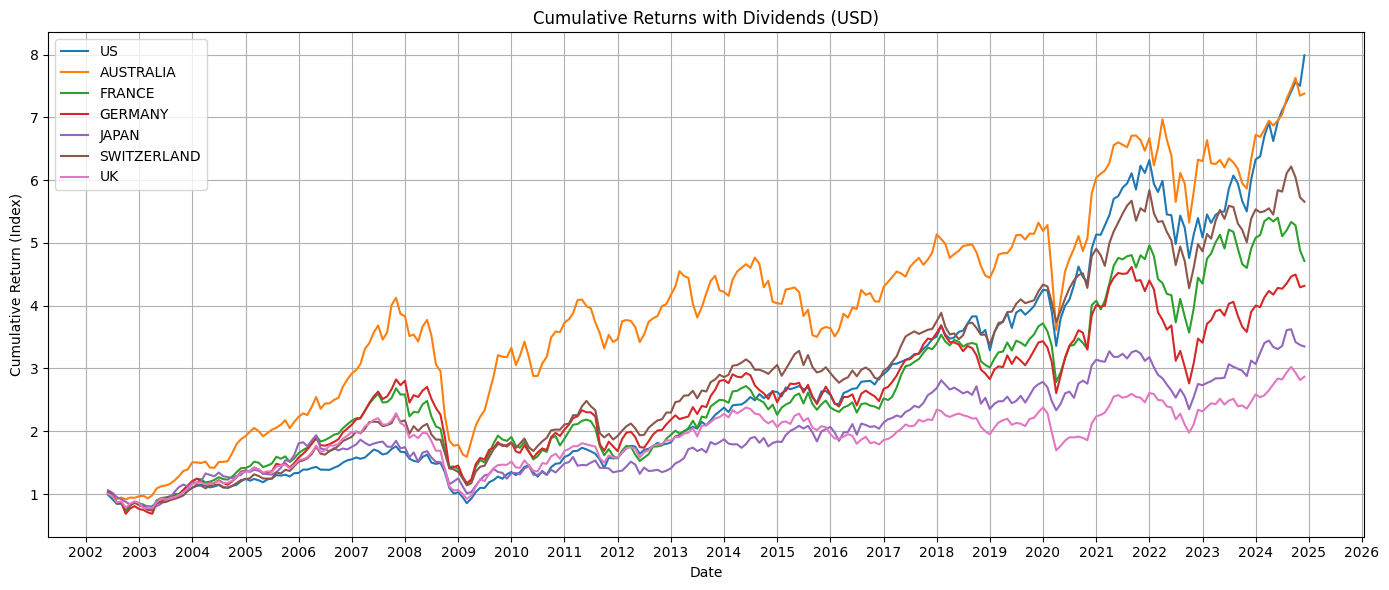

In [238]:
# Plotting the monthly returns in USD for all countries


# Import the monthly returns in USD data
df_monthly_return_usd = pd.read_csv("data/q3/monthly_returns_in_usd.csv", parse_dates=['date'], index_col='date')

# Identify columns with dividends
cols_with_div = [col for col in df_monthly_return_usd.columns if 'ret_with_div_usd' in col]

# Function to plot time series of monthly returns in 6 subplots
def plot_returns_subplots(df, cols, title):
    n = len(cols)
    nrows, ncols = 2, 3  # 6 countries → 2 rows x 3 columns

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), sharex=True)
    axes = axes.flatten()  # Flatten the 2D array for easy iteration

    for i, col in enumerate(cols):
        ax = axes[i]
        # Clean up the label for the title (e.g., 'uk_ret_with_div_usd' → 'Uk')
        label = col.replace('_ret_with_div_usd', '').replace('_', ' ').title().upper()
        ax.plot(df.index, df[col], label=label)
        ax.set_title(label)
        ax.grid(True)

    # Set common title and axis labels
    fig.suptitle(title, fontsize=16)
    fig.text(0.5, 0.04, "Date", ha='center', fontsize=12)
    fig.text(0.04, 0.5, "Monthly Return (USD)", va='center', rotation='vertical', fontsize=12)

    # Adjust layout to fit all elements properly
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.show()

# Function to plot cumulative returns (compounded growth)
def plot_cumulative_returns(df, cols, title):
    plt.figure(figsize=(14, 6))
    for col in cols:
        cumulative_return = (1 + df[col]).cumprod()  # Compound monthly returns
        label = col.replace('_ret_with_div_usd', '').upper()
        plt.plot(df.index, cumulative_return, label=label)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Index)')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Format x-axis to show years only
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.tight_layout()
    plt.show()

# Plot monthly returns with dividends in USD
#plot_returns_subplots(df_monthly_return_usd, cols_with_div, 'Monthly Returns with Dividends (USD)')

# Plot cumulative returns
plot_cumulative_returns(df_monthly_return_usd, cols_with_div, 'Cumulative Returns with Dividends (USD)')

In [239]:
# Q3b

# Load data
df_returns_in_usd = pd.read_csv("./data/q3/monthly_returns_in_usd.csv", parse_dates=["date"], index_col='date')
df_fx_rf = pd.read_csv("data/preprocess/merged_three_month_interbank_rates.csv", parse_dates=["date"], index_col='date')
df_exchange_rates = pd.read_csv("data/preprocess/merged_exchange_rates.csv", parse_dates=["date"], index_col='date')

# Merge datasets on the date column and sort chronologically
df_hedged_returns = pd.merge(df_returns_in_usd, df_fx_rf, on="date", how="right")
df_hedged_returns = pd.merge(df_hedged_returns, df_exchange_rates, on="date", how="right")

# Map countries to relevant columns (currency, local interest rate, FX rate)
country_map = {
    "australia": {"ccy": "aud", "rate_col": "three_month_interbank_rate_AUD", "fx_col": "USD_per_AUD"},
    "france": {"ccy": "eur", "rate_col": "three_month_interbank_rate_EUR", "fx_col": "USD_per_EUR"},
    "germany": {"ccy": "eur", "rate_col": "three_month_interbank_rate_EUR", "fx_col": "USD_per_EUR"},
    "japan": {"ccy": "jpy", "rate_col": "three_month_interbank_rate_JPY", "fx_col": "USD_per_JPY"},
    "switzerland": {"ccy": "chf", "rate_col": "three_month_interbank_rate_CHF", "fx_col": "USD_per_CHF"},
    "uk": {"ccy": "gbp", "rate_col": "three_month_interbank_rate_GBP", "fx_col": "USD_per_GBP"},
}

# Extract US 3-month interbank rate from returns data
df_hedged_returns["r_us"] = df_hedged_returns["three_month_interbank_rate_USD"]

# Compute excess currency return and hedged stock index return for each country
for country, meta in country_map.items():
    ret_col = f"{country}_ret_with_div_usd"  # Local index return in USD
    fx_col = meta["fx_col"]  # Spot exchange rate: USD per 1 unit of local currency
    r_local_col = meta["rate_col"]  # Local short-term risk-free rate

    fx_t = df_hedged_returns[fx_col]                 # Spot FX rate at time t (USD per local currency)
    fx_tm1 = fx_t.shift(1)                           # Spot FX rate at time t-1
    r_local = df_hedged_returns[r_local_col]         # Local interest rate (3-month interbank rate)
    r_us = df_hedged_returns["r_us"]                 # US interest rate (3-month interbank rate)
    r_local_return = df_hedged_returns[ret_col]      # Local index return in USD
    # Currency excess return (X), following the formula:
    # X_t = (S_{t} / S_{t-1}) * (1 + r^{local}_{t-1}) - (1 + r^{us}_{t-1})
    df_hedged_returns[f"X_{country}"] = (fx_t / fx_tm1) * (1 + r_local.shift(1)) - (1 + r_us.shift(1))

    # Currency-hedged return in USD = local return - currency excess return
    # df_hedged_returns[f"{country}_local_return"] = r_local_return
    df_hedged_returns[f"{country}_hedged_return_usd"] = r_local_return - df_hedged_returns[f"X_{country}"]

# Select and export hedged return columns
hedged_cols = [col for col in df_hedged_returns.columns if col.endswith("_hedged_return_usd")]
df_hedged_returns = df_hedged_returns[hedged_cols]
df_hedged_returns.dropna(inplace=True)  # Drop rows with NaN values

# Save final result to CSV
df_hedged_returns.to_csv("data/q3/hedged_returns.csv")

# Display first few rows of the result
df_hedged_returns.head()

,australia_hedged_return_usd,france_hedged_return_usd,germany_hedged_return_usd,japan_hedged_return_usd,switzerland_hedged_return_usd,uk_hedged_return_usd
date,,,,,,
2002-06-01,-0.032030,-0.047160,-0.044748,0.054278,0.009252,-0.035688
2002-07-01,-0.057393,-0.101862,-0.089264,-0.070745,-0.079388,-0.112300
2002-08-01,-0.067738,-0.118127,-0.122877,-0.040030,-0.122092,-0.110588
2002-09-01,-0.016413,-0.020937,-0.019208,-0.007512,0.015695,-0.020161
2002-10-01,-0.071745,-0.164219,-0.220553,-0.003870,-0.077993,-0.136824


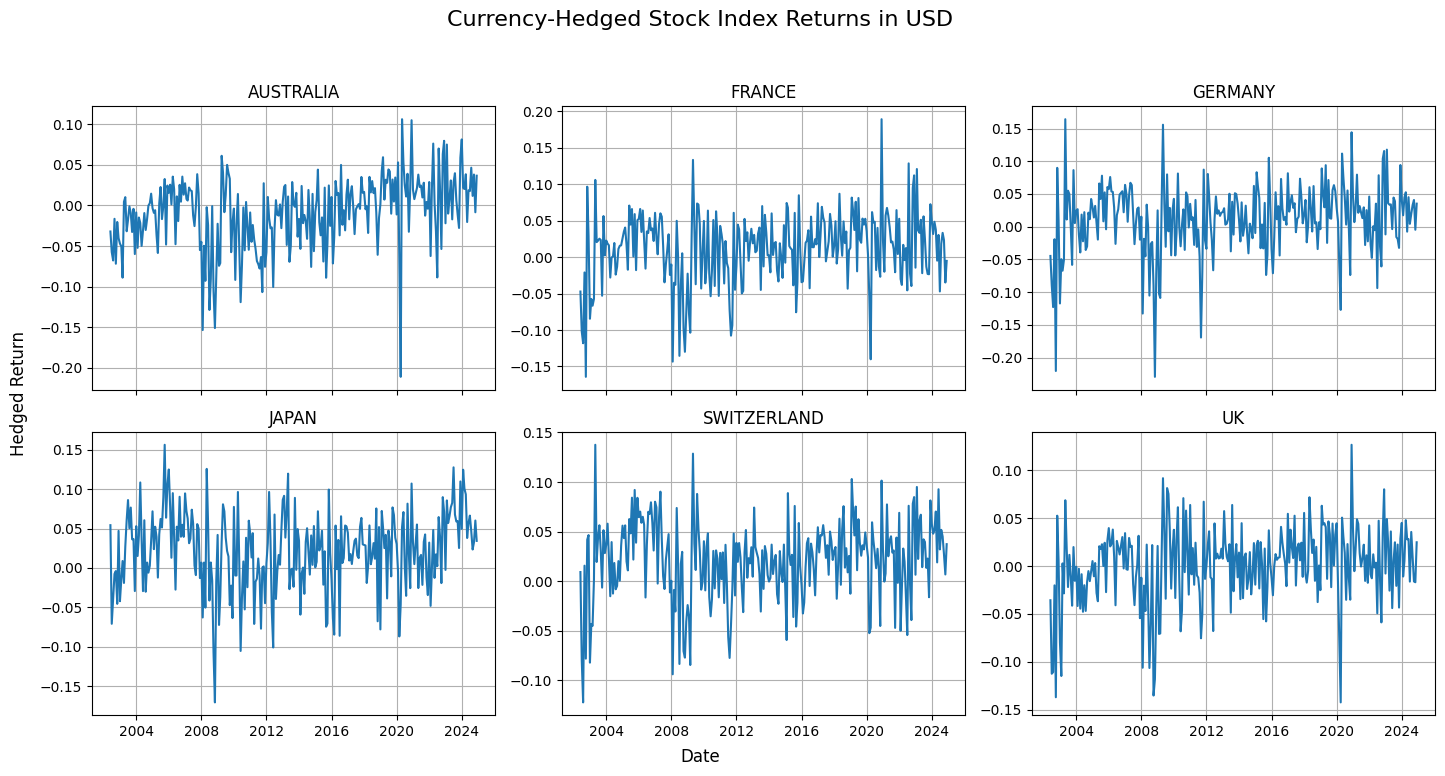

In [240]:
# Load the data
df_hedged_returns = pd.read_csv("data/q3/hedged_returns.csv", parse_dates=['date'], index_col='date')

# Create subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
axes = axes.flatten()  # Flatten the 2D array for easy indexing

# Plot each country's data
for i, country in enumerate(country_map.keys()):
    ax = axes[i]
    hedged_col = f"{country}_hedged_return_usd"
    
    if hedged_col in df_hedged_returns.columns:
        ax.plot(df_hedged_returns.index, df_hedged_returns[hedged_col])
        ax.set_title(country.upper())
        ax.grid(True)

# Common labels and layout adjustments
fig.suptitle("Currency-Hedged Stock Index Returns in USD", fontsize=16)
fig.text(0.5, 0.04, "Date", ha='center', fontsize=12)
fig.text(0.04, 0.5, "Hedged Return", va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

In [270]:
#Q3c
# METHODS FOR ALL PORTFOLIOS
def equal_weighted(returns: pd.DataFrame, rf_series: pd.Series):
    nb_countries = returns.shape[1]
    return_a = (returns * (1 / nb_countries)).sum(axis=1)
    mean_a = 12*return_a.mean()
    std_a = np.sqrt(12)*return_a.std()
    sharpe_a = (mean_a - 12*rf_series.mean()) / std_a

    print("EQUALLY WEIGHTED : ")
    print(f"Mean return : {mean_a}")
    print(f"Standard deviation : {std_a}")
    print(f"Sharpe ratio : {sharpe_a}")


def risk_parity(returns: pd.DataFrame, rf_series: pd.Series):
    rolling_vol = returns.rolling(window=60).std().dropna()
    inv_vol = 1 / rolling_vol
    weights = inv_vol.div(inv_vol.sum(axis=1), axis=0).shift(1).dropna()
    returns_aligned = returns.loc[weights.index]
    return_b = (weights * returns_aligned).sum(axis=1).dropna()
    mean_b = 12*return_b.mean()
    std_b = np.sqrt(12)*return_b.std()
    sharpe_b = (mean_b - 12*rf_series.mean()) / std_b

    print("RISK-PARITY : ")
    print(f"Mean return : {mean_b}")
    print(f"Standard deviation : {std_b}")
    print(f"Sharpe ratio : {sharpe_b}")

    return return_b.to_frame()

def mean_variance(returns: pd.DataFrame, rf_series: pd.Series):
    rolling_mean = returns.rolling(window=60).mean().dropna()
    rolling_cov = returns.rolling(window=60).cov().dropna()

    mv_weights = []
    dates_mv = rolling_mean.index
    columns = returns.columns

    for date in dates_mv:
        mu = rolling_mean.loc[date]
        Sigma = rolling_cov.loc[date]
        rf = rf_series.loc[date]
        excess = mu - rf
        w = inv(Sigma) @ excess
        mv_weights.append(w)


    mv_weights_df = pd.DataFrame(mv_weights, index=dates_mv, columns=columns)
    returns_aligned_mv = returns.loc[mv_weights_df.index]
    weighted_returns = mv_weights_df * returns_aligned_mv
    return_c = (weighted_returns).sum(axis=1)
    mean_c = 12*return_c.mean()
    std_c = np.sqrt(12)*return_c.std()
    sharpe_c = (mean_c - 12*rf_series.mean()) / std_c

    print("MEAN-VARIANCE OPTIMAL:")
    print(f"Mean return : {mean_c}")
    print(f"Standard deviation : {std_c}")
    print(f"Sharpe ratio : {sharpe_c}")
    




In [271]:
#Q3c
# HEDGED PART
# Part a
# Remove US data from dataframe as we want to invest internationally (?)
inter_hedged = df_hedged_returns
print("HEDGED : \n")
equal_weighted(inter_hedged, df_tbills["rf"])
div_return = risk_parity(inter_hedged, df_tbills["rf"])
mean_variance(inter_hedged, df_tbills["rf"])

HEDGED : 

EQUALLY WEIGHTED : 
Mean return : 0.11684871541080089
Standard deviation : 0.14031587542380478
Sharpe ratio : 0.7260417660605845
RISK-PARITY : 
Mean return : 0.1073337541565843
Standard deviation : 0.13974915725142228
Sharpe ratio : 0.660900048067228
MEAN-VARIANCE OPTIMAL:
Mean return : 21.760264226368026
Standard deviation : 6.2294875021093015
Sharpe ratio : 3.490702997572965


In [246]:
#Q3c
# UNHEDGED PART
# Part a
# Remove US data from dataframe as we want to invest internationally (?)
inter_unhedged = df_monthly_return_usd.drop(columns="us_ret_with_div_usd")

print("UNHEDGED : \n")
equal_weighted(inter_unhedged, df_tbills["rf"])
risk_parity(inter_unhedged, df_tbills["rf"])
mean_variance(inter_unhedged, df_tbills["rf"])

UNHEDGED : 

EQUALLY WEIGHTED : 
Mean return : 0.08247102568683061
Standard deviation : 0.15628525693349335
Sharpe ratio : 0.43188652339605665
RISK-PARITY : 
Mean return : 0.05210431800739962
Standard deviation : 0.15835315034122754
Sharpe ratio : 0.2344808961212554
MEAN-VARIANCE OPTIMAL:
Mean return : 1.6152380403547197
Standard deviation : 1.4082940930891983
Sharpe ratio : 1.1363141539794825


In [272]:
# Q3d : div_return stores the returns needed for next exercises in csv 
div_return = div_return.rename(columns={0:"DIV_return"})
div_return.to_csv("data/q3/div_return.csv")